In [1]:
import sys
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
# search the number of visible points
def search_f(path):
    dif = []
    for k in range(1,int(len(path)*0.4)+1): # 30 % of trajectory 200*0.3=  max njmbre of missing points = 40 pts
        sd = round(np.std(path[0:-k]),4) # sd for point visible 
        sd_kstep = round(np.sqrt(k),4) # nombre the point to predicted sqrt(k)
        dif.append(round(abs(sd_kstep-sd),4))
    mi = np.min(dif)
    f = dif.index(mi) # missing positions index
    return f

In [3]:

df_rdw_lr = pd.read_csv('C:/Users/USER/Desktop/Paris Saclay/These/2_SCRIPT/exp_1/path_150/rdw_left_right_150.csv', header=None, )

df_iid_lr = pd.read_csv('C:/Users/USER/Desktop/Paris Saclay/These/2_SCRIPT/exp_1/path_150/iid_left_right_150.csv', header=None, )
df_rdw_ll = pd.read_csv('C:/Users/USER/Desktop/Paris Saclay/These/2_SCRIPT/exp_1/path_150/rdw_left_left_150.csv', header=None, )
df_iid_ll = pd.read_csv('C:/Users/USER/Desktop/Paris Saclay/These/2_SCRIPT/exp_1/path_150/iid_left_left_150.csv', header=None, )

In [4]:
def df_to_path_list(data):
    trajectories = []
    for col in data.columns:
        trajectory = data[col].values

        trajectory = trajectory[~np.isnan(trajectory)]
        trajectories.append(trajectory)
        
    updated_trajectories = []
    for col in data.columns:
        trajectory = data[col].values
        zero_index = len(trajectory) - np.argmax(trajectory[::-1] != 0) if np.any(trajectory != 0) else 0
        updated_trajectory = trajectory[:zero_index]
        updated_trajectories.append(updated_trajectory)
    return updated_trajectories

In [5]:
rdw_lr = df_to_path_list(df_rdw_lr)
iid_lr = df_to_path_list(df_iid_lr)
len(rdw_lr),len(iid_lr), rdw_lr[:1]  ,  iid_lr[:1]  

(50,
 50,
 [array([ 0.00000000e+00,  1.17259962e+00,  2.83630163e+00,  1.73199042e+00,
          8.10151599e-01,  1.29776343e+00,  8.89625244e-01,  1.56102625e+00,
         -3.33315376e-01, -1.38211466e-01,  2.14953947e-01,  4.17255456e-01,
         -4.93572427e-01,  1.60288718e-01, -1.33184646e+00, -1.25797310e+00,
          1.66973428e-01,  1.48550598e+00,  2.10865177e+00,  1.47333526e+00,
          1.57616500e+00,  4.40352848e-01,  9.80015972e-01, -1.29966946e+00,
         -1.00062549e+00, -2.02312852e+00, -1.91385429e+00, -1.89169434e+00,
          2.77537998e-02, -1.27716816e+00, -2.33673743e+00, -2.27187959e+00,
         -1.65942062e+00, -1.43827860e+00, -2.15131223e+00, -1.06955541e+00,
         -2.16535722e+00, -7.10040274e-01,  7.06802620e-01, -1.41764304e+00,
         -7.28580960e-01,  2.74646728e-03, -4.78814959e-01, -1.43778490e+00,
         -2.77989927e+00, -2.88522629e+00, -3.12145772e+00, -3.29663420e+00,
         -3.61011955e+00, -4.24576174e+00, -4.97556444e+00, -3.730

In [6]:
rdw_ll = df_to_path_list(df_rdw_ll)
iid_ll = df_to_path_list(df_iid_ll)
len(rdw_ll),len(iid_ll)

(50, 50)

In [16]:
def check_mean_condition_5(iid_trajectory, original_mean, tolerance=0.1):
    last_5_percent = int(len(iid_trajectory)*0.05)
    mean_last_5 = np.mean(iid_trajectory[-last_5_percent:])
    last_10_percent = int(len(iid_trajectory) * 0.1)
    mean_last_10 = np.mean(iid_trajectory[-last_10_percent:])
    last_15_percent = int(len(iid_trajectory) * 0.15)
    mean_last_15 = np.mean(iid_trajectory[-last_15_percent:])
    
    return (np.abs(np.abs(original_mean) - np.abs(mean_last_5)) <= tolerance  and np.sign(original_mean) != np.sign(mean_last_5) and
            np.sign(original_mean) == np.sign(mean_last_15) and np.sign(original_mean) == np.sign(mean_last_10))
    

def check_mean_condition_15(iid_trajectory, original_mean, tolerance=0.1):
    last_5_percent = int(len(iid_trajectory) * 0.05)
    mean_last_5 = np.mean(iid_trajectory[-last_5_percent:])
    last_10_percent = int(len(iid_trajectory) * 0.1)
    mean_last_10 = np.mean(iid_trajectory[-last_10_percent:])
    last_15_percent = int(len(iid_trajectory) * 0.15)
    mean_last_15 = np.mean(iid_trajectory[-last_15_percent:])
#     mean_last_5 = np.mean(iid_trajectory[-5:])
#     mean_last_10 = np.mean(iid_trajectory[-10:])
#     mean_last_15 = np.mean(iid_trajectory[-15:])

    return (np.sign(original_mean) != np.sign(mean_last_10) and 
            np.abs(np.abs(original_mean) - np.abs(mean_last_15)) <= tolerance and np.sign(original_mean) != np.sign(mean_last_15) and 
            np.abs(np.abs(original_mean) - np.abs(mean_last_5)) <= 0.1 and np.sign(original_mean) != np.sign(mean_last_5))
   

def make_new_iid (rdw_samples, num_last):
    max_attempts =500000
    iid_trajectories = []
    for i in range(len(rdw_samples)):
        elem = rdw_samples[i]
        original_mean = np.mean(elem)
        condition_met = False
        attempts = 0 
        while not condition_met and attempts < max_attempts:
            iid = np.random.choice(elem[1:-1], len(elem)-2, replace=False)
            iid = np.insert(iid, 0, elem[0])  # same start like RDW
            iid = np.append(iid, elem[-1])   # same end like RDW
            
            # Check mean condition
            if num_last == "5":
                
                condition_met = check_mean_condition_5(iid, original_mean)
    #         condition_met = check_mean_condition(iid, elem)
            else:
                condition_met = check_mean_condition_15(iid, original_mean)
            attempts += 1 
#         iid_trajectories.append(iid)
        if condition_met:
            iid_trajectories.append(iid)
            print(f"{i} -- ok")
        else:
            iid_trajectories.append(np.zeros((150,), dtype=int))
            print(f"{i} --fail after  {max_attempts} .")
        
    return  iid_trajectories

In [12]:
iid_lr_last5 = make_new_iid (rdw_lr, "5")

0 --fail after  50000 .
1 -- ok
2 -- ok
3 -- ok
4 -- ok
5 -- ok
6 -- ok
7 -- ok
8 -- ok
9 -- ok
10 -- ok
11 -- ok
12 -- ok
13 -- ok
14 -- ok
15 -- ok
16 -- ok
17 -- ok
18 -- ok
19 -- ok
20 -- ok
21 -- ok
22 -- ok
23 -- ok
24 -- ok
25 -- ok
26 -- ok
27 -- ok
28 -- ok
29 -- ok
30 -- ok
31 -- ok
32 -- ok
33 -- ok
34 -- ok
35 -- ok
36 -- ok
37 -- ok
38 -- ok
39 -- ok
40 -- ok
41 -- ok
42 -- ok
43 -- ok
44 -- ok
45 -- ok
46 -- ok
47 -- ok
48 -- ok
49 -- ok


In [17]:
iid_lr_last15 = make_new_iid (rdw_lr, "15")

0 --fail after  500000 .
1 -- ok
2 --fail after  500000 .
3 -- ok
4 -- ok
5 --fail after  500000 .
6 -- ok
7 --fail after  500000 .
8 --fail after  500000 .
9 --fail after  500000 .
10 -- ok
11 -- ok
12 -- ok
13 --fail after  500000 .


KeyboardInterrupt: 

In [ ]:
for elem in  iid_lr_last15:
    last = int(len(elem) * 0.05)
    total = np.round(np.mean(elem),2)
    last = np.round(np.mean(elem[-int(len(elem) * 0.05):]),2)
    last_10 = np.round(np.mean(elem[-int(len(elem) * 0.1):]),2)
    last_15 = np.round(np.mean(elem[-int(len(elem) * 0.15):]),2)
    print(total,last_15, np.abs(np.round(np.abs(total)-np.abs(last_15),2))) 

In [18]:
def save_csv (rdw_list, name):
    save =  np.zeros((150, 50))
    for i in range(len(rdw_list)):
#         save[:,i] = rdw_list[i]
        save[:len(rdw_list[i]),i] = rdw_list[i]
    save = save.astype('float')
#         save[1:,][save[1:,] == 0] = np.nan
    np.savetxt(name, save , delimiter=",")
    return save

C:\Users\USER\AppData\Local\Temp\ipykernel_9940\1612141321.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15, 10))


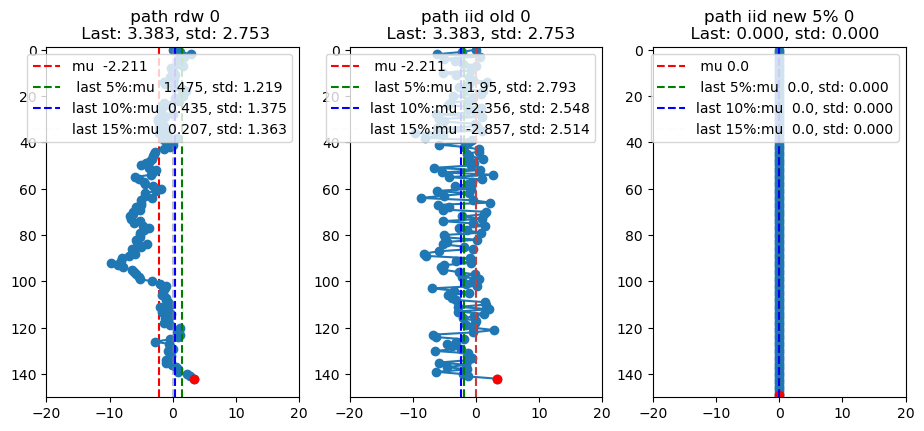

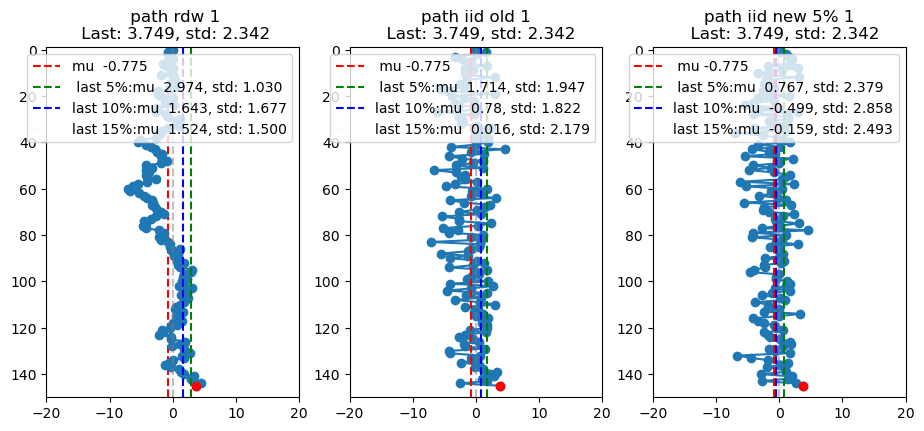

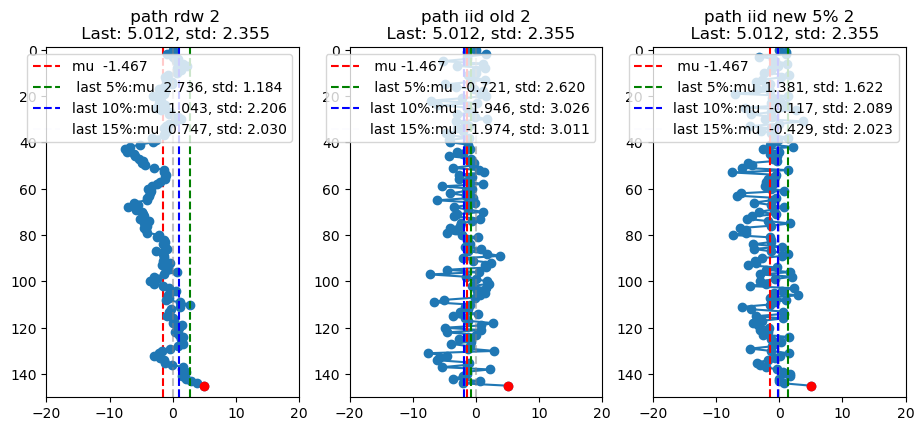

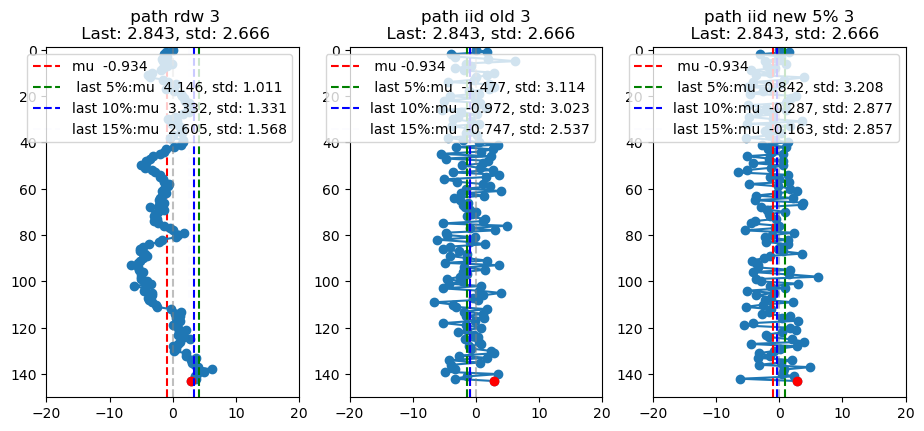

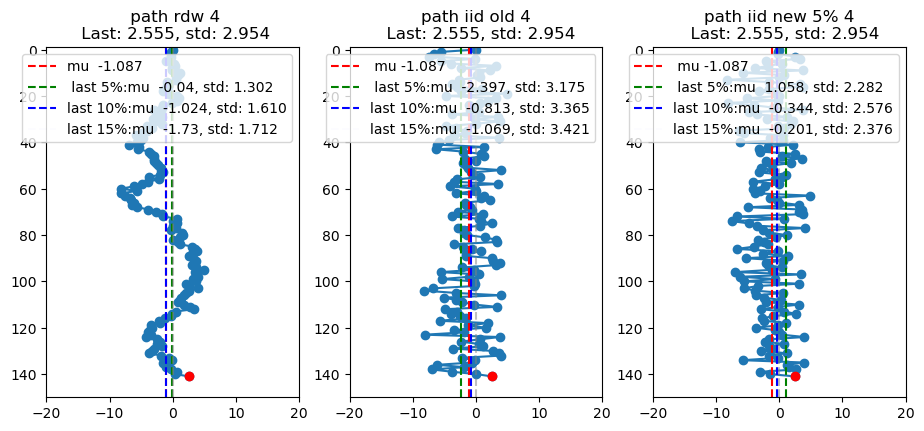

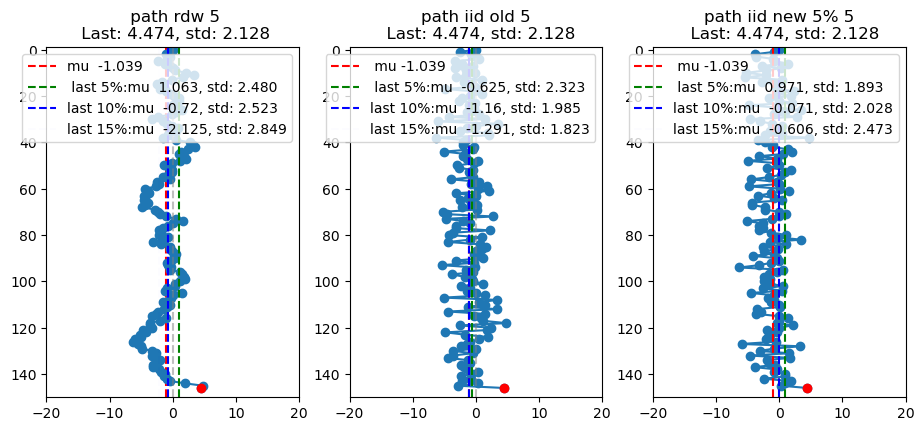

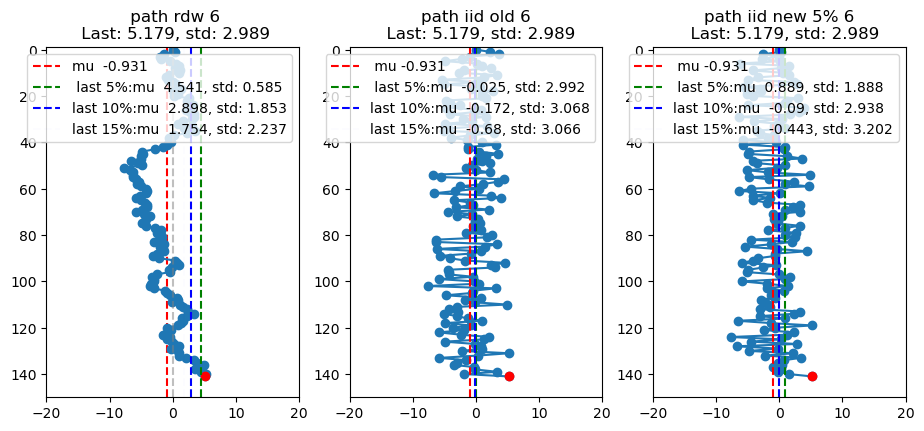

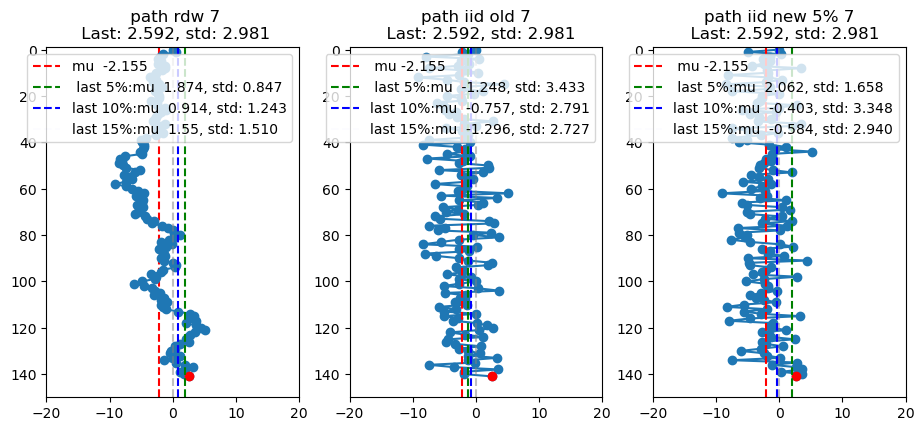

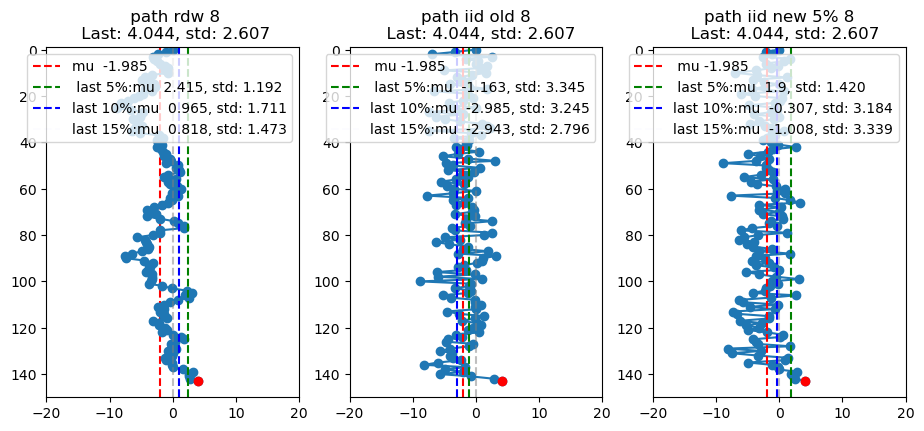

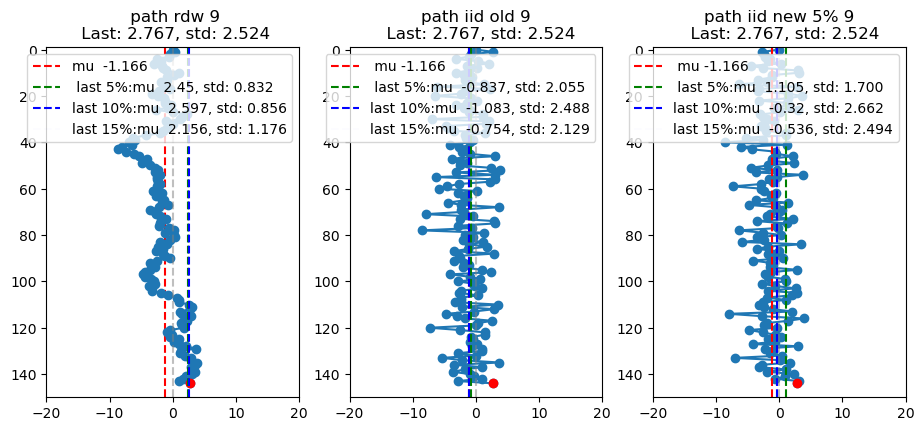

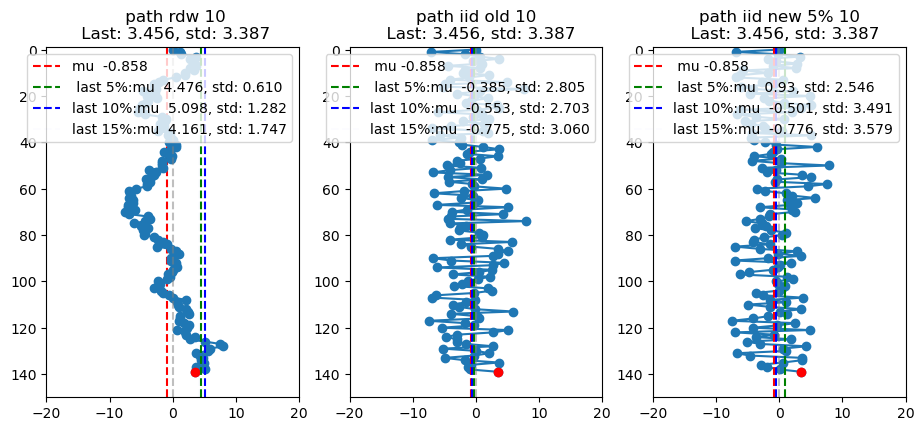

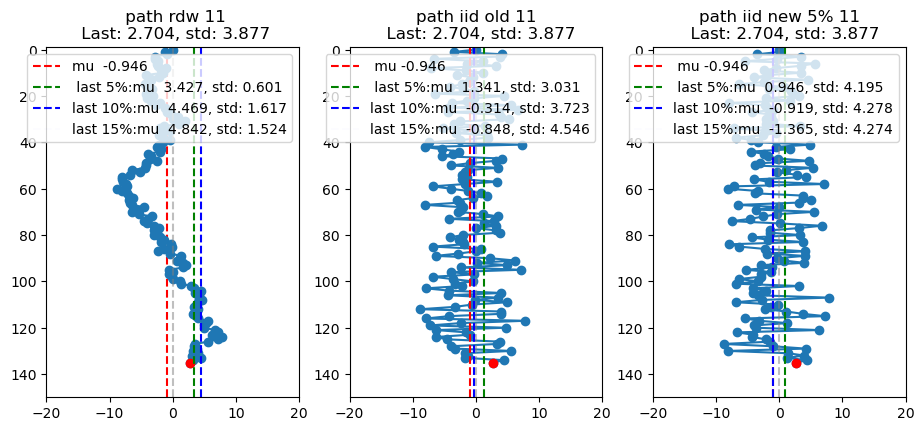

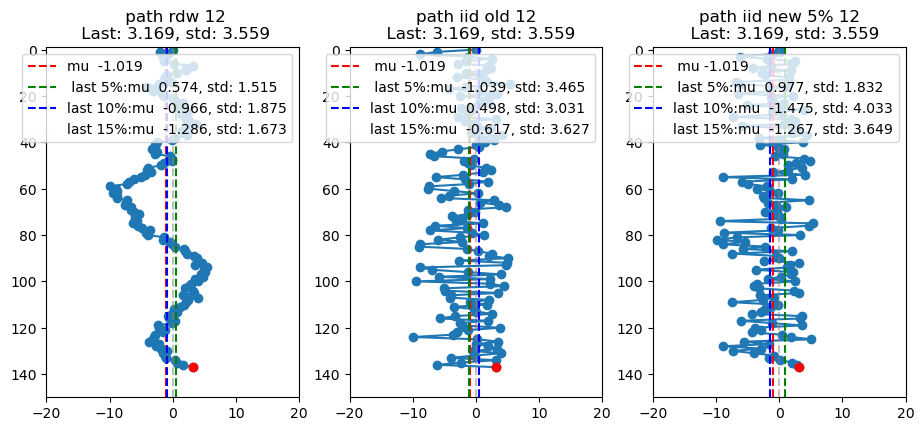

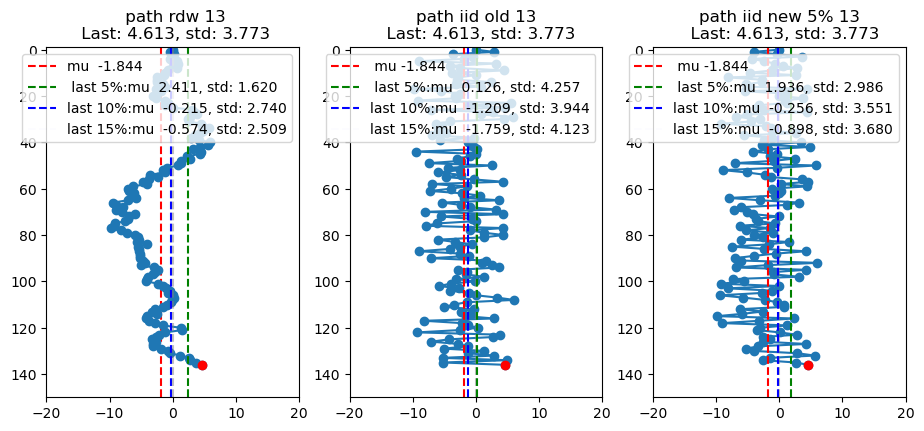

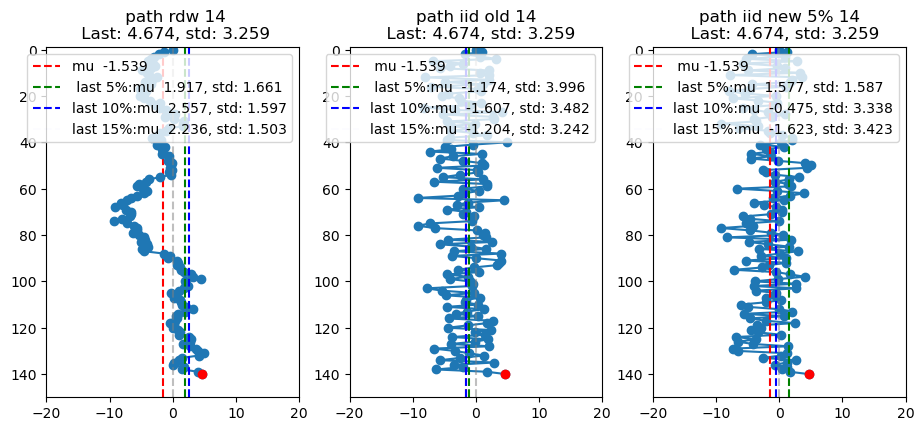

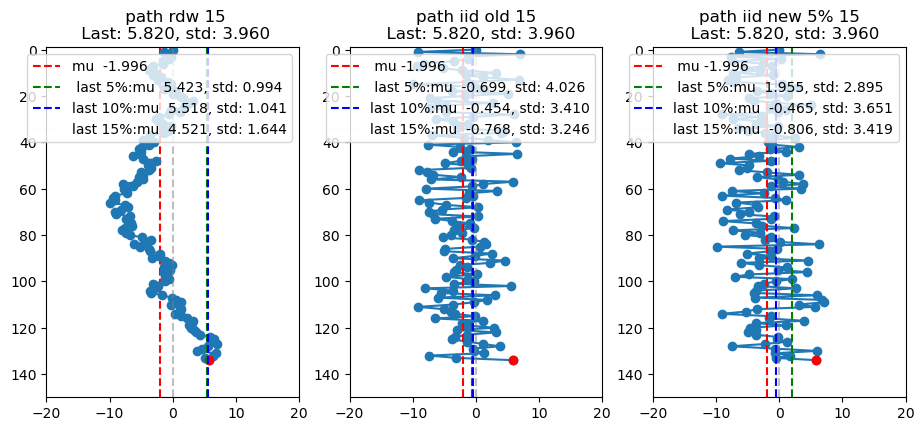

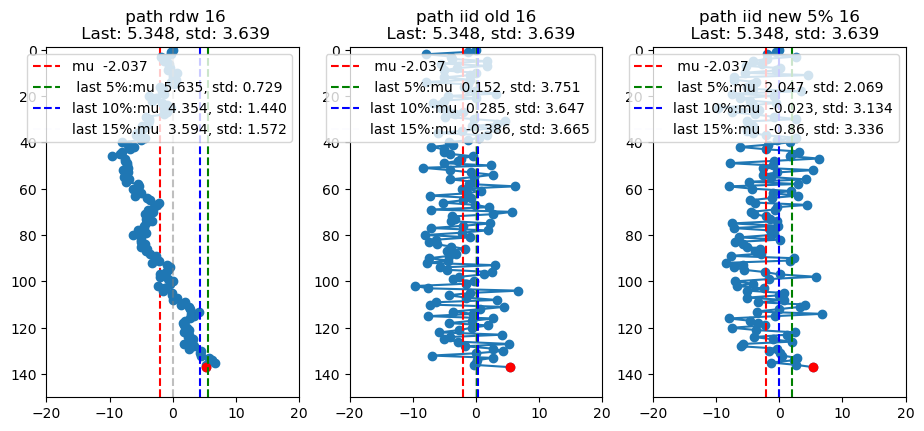

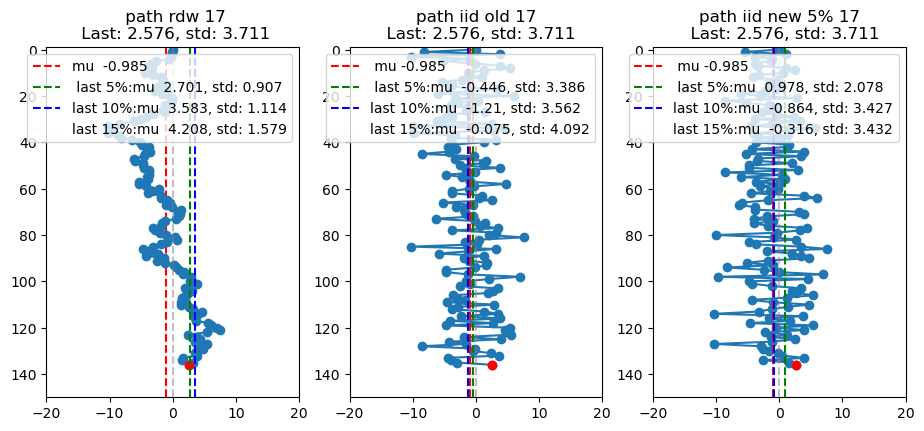

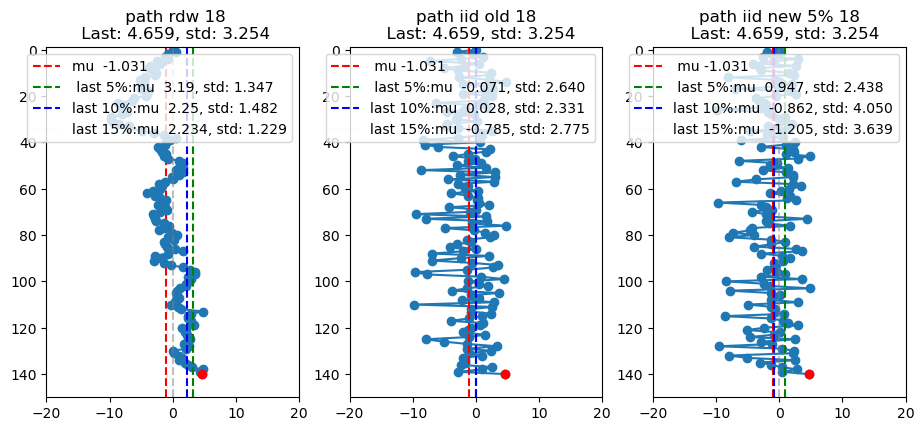

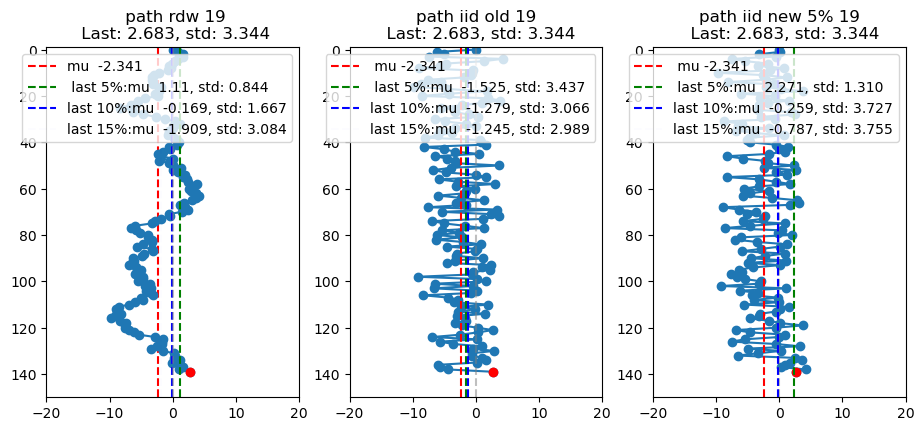

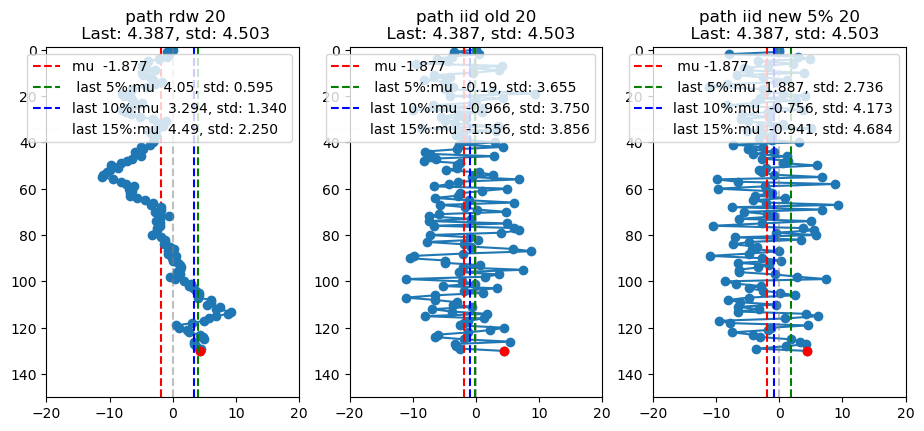

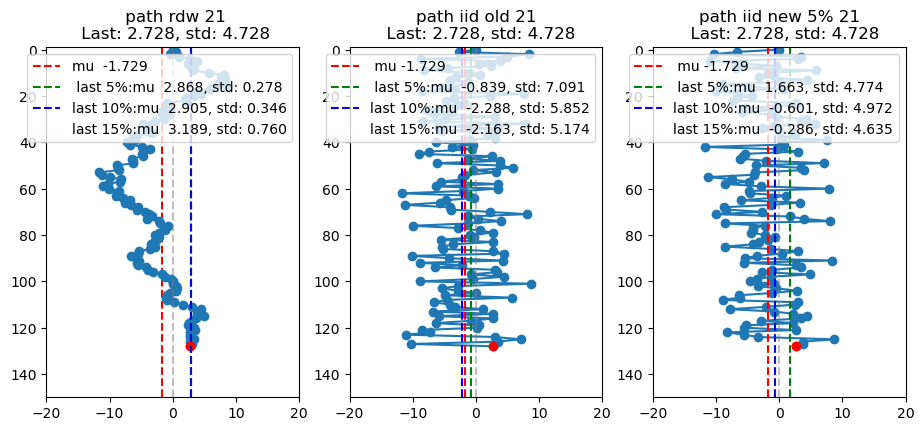

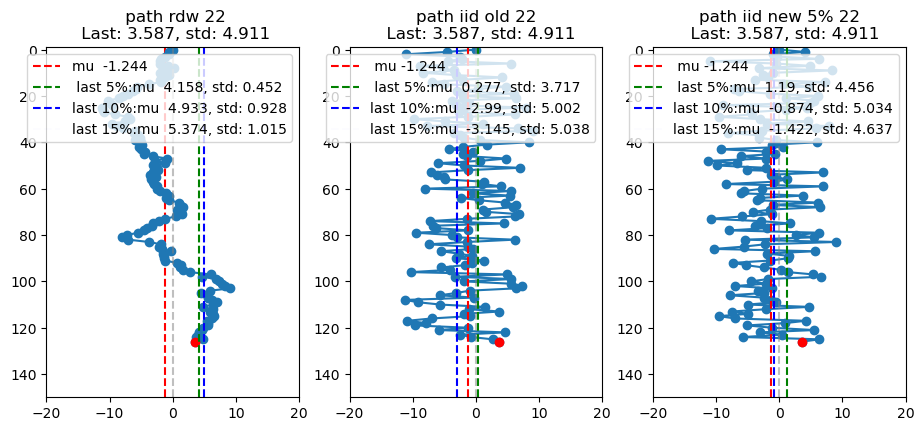

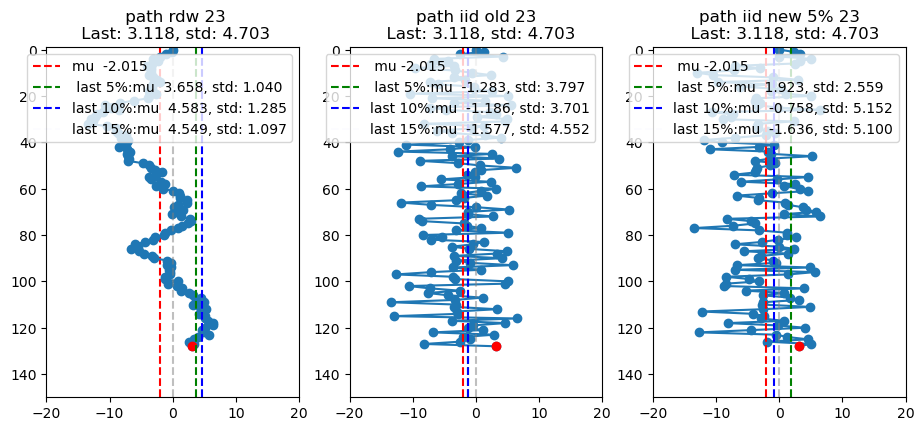

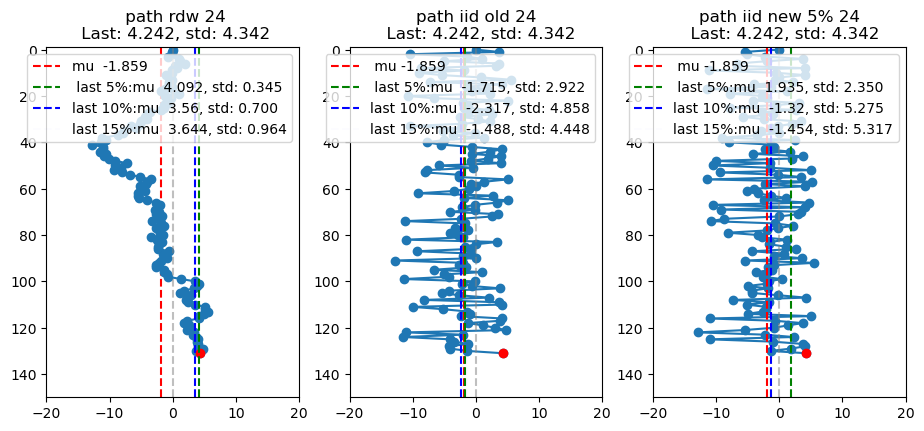

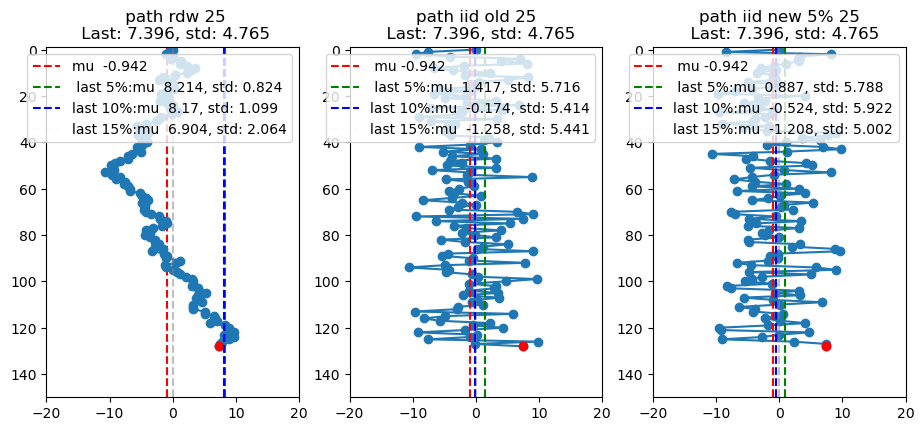

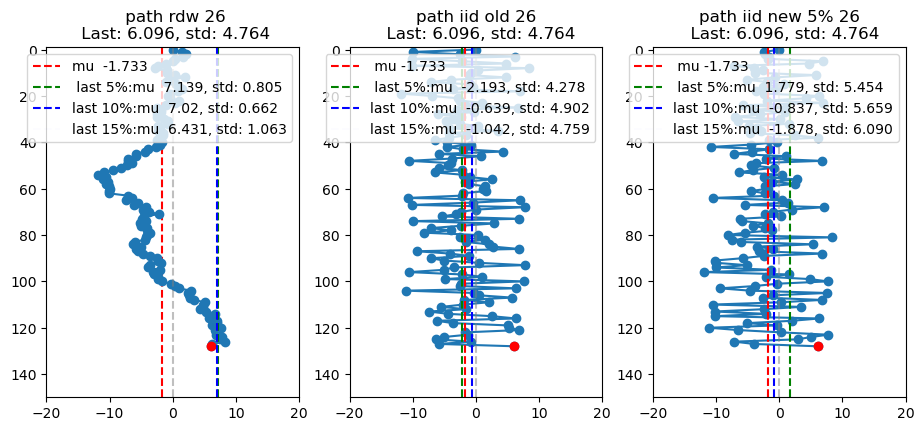

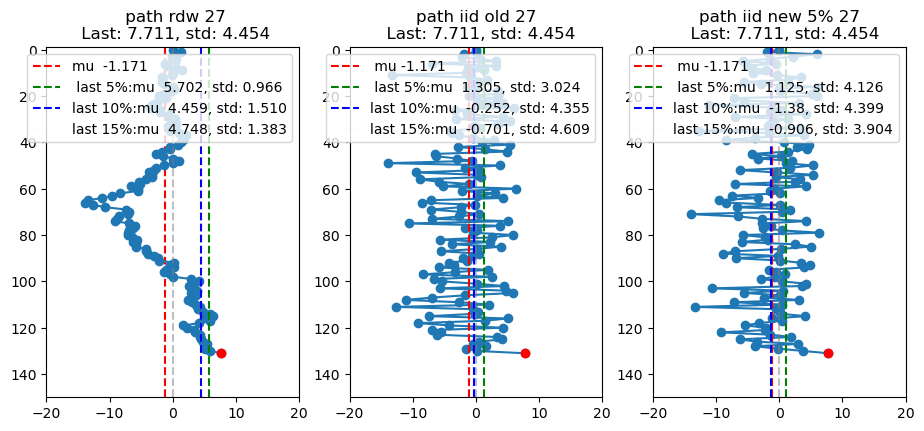

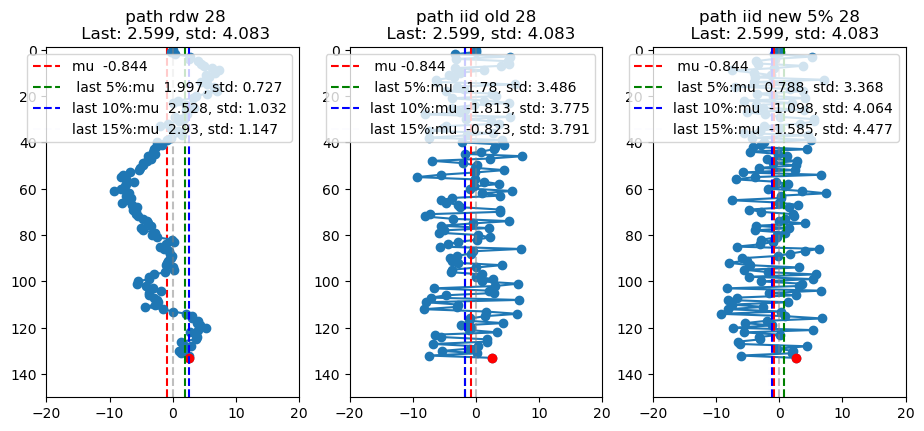

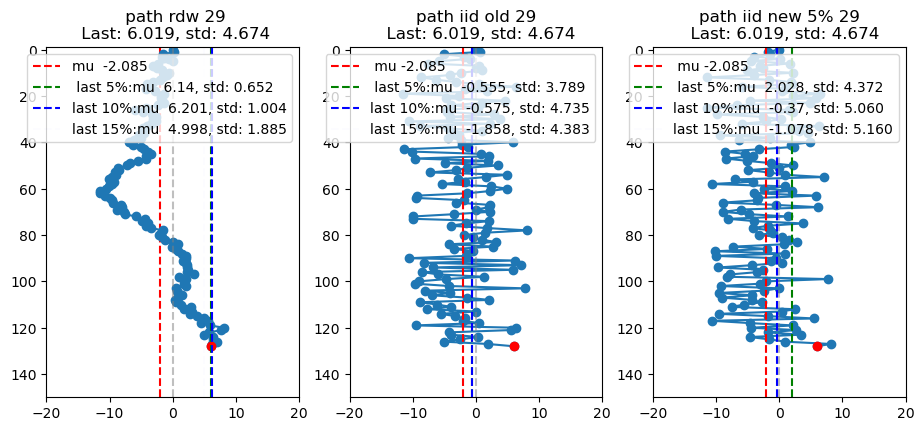

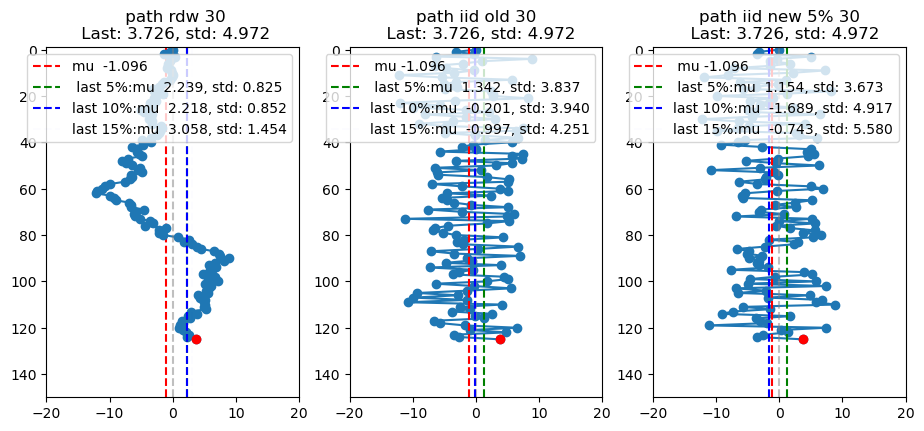

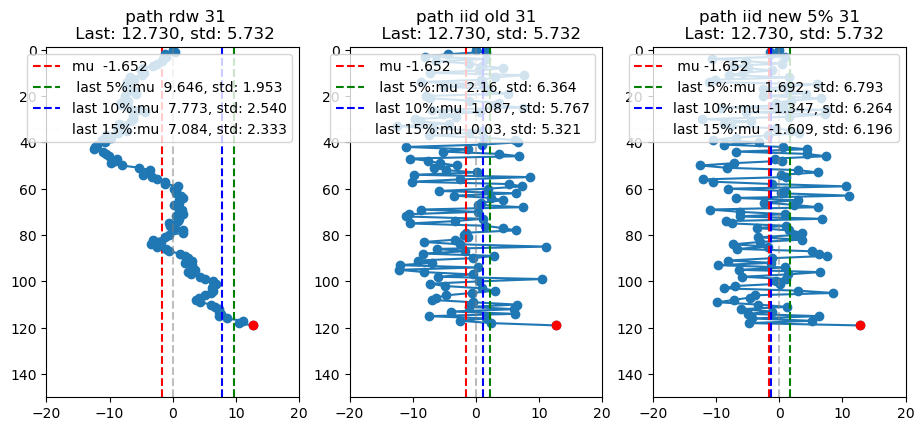

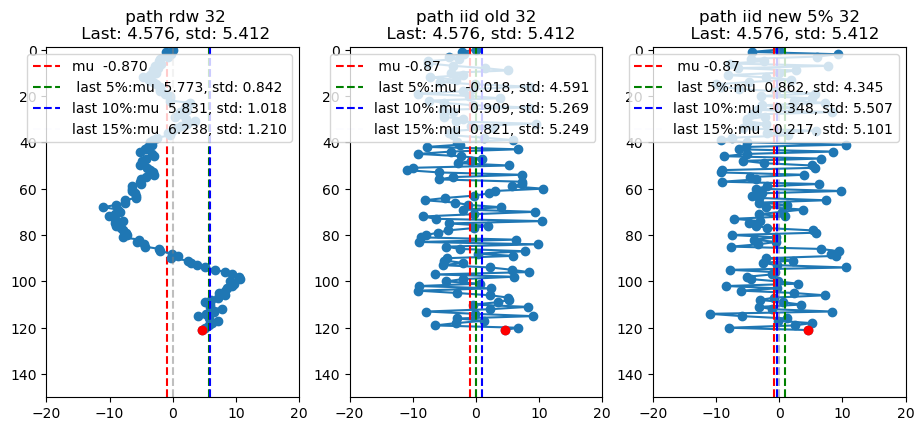

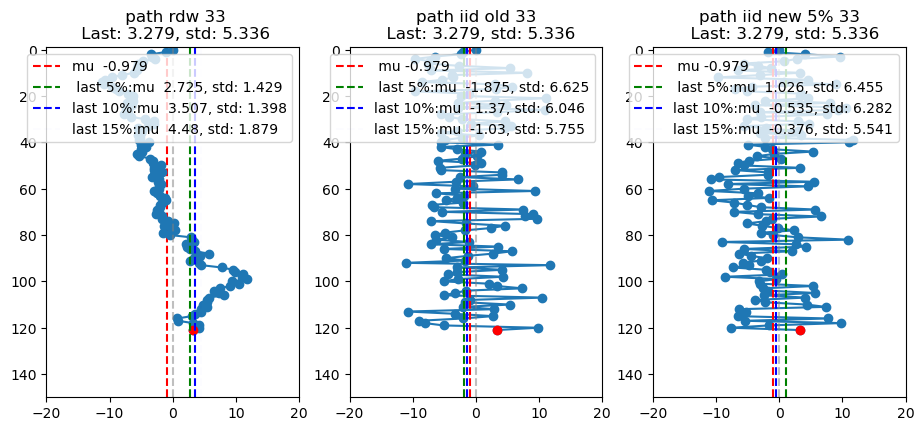

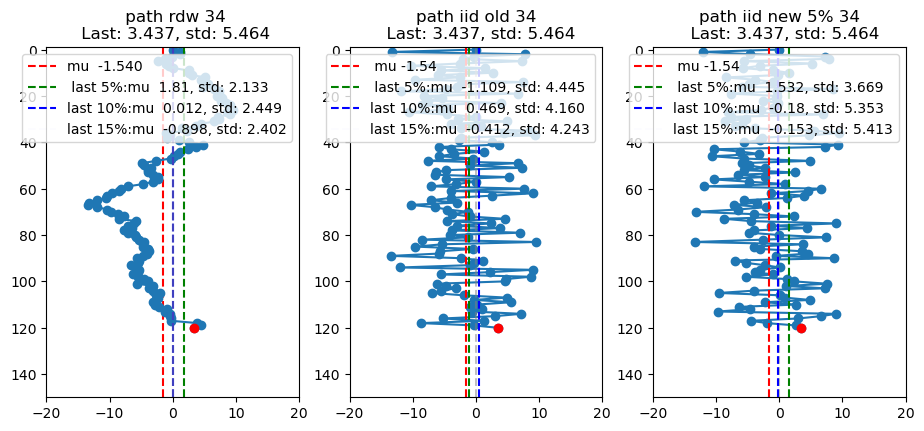

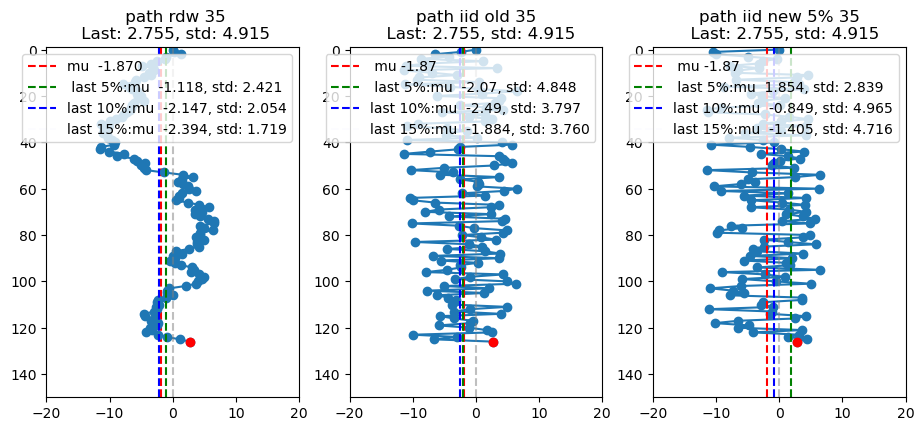

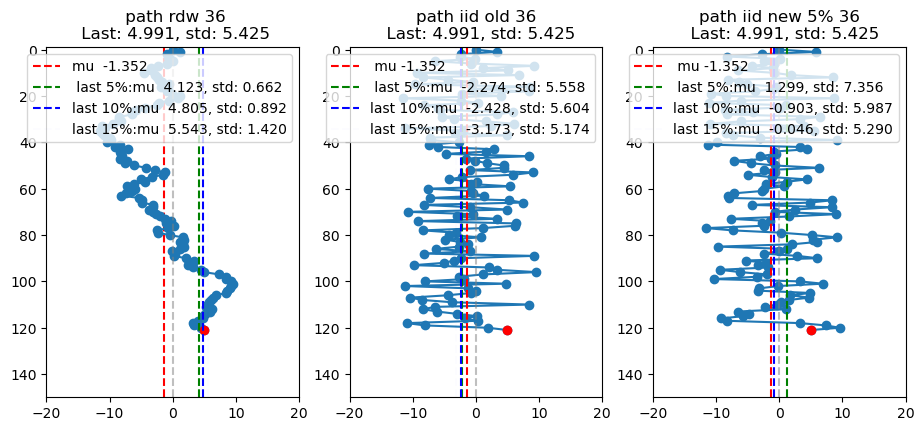

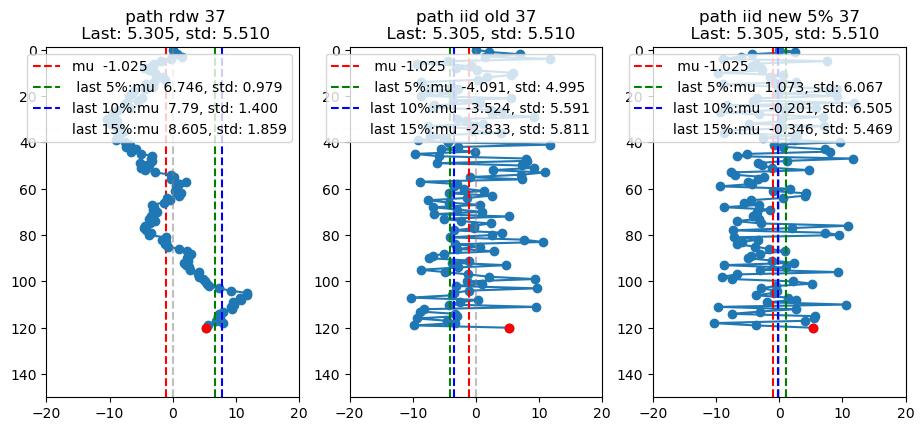

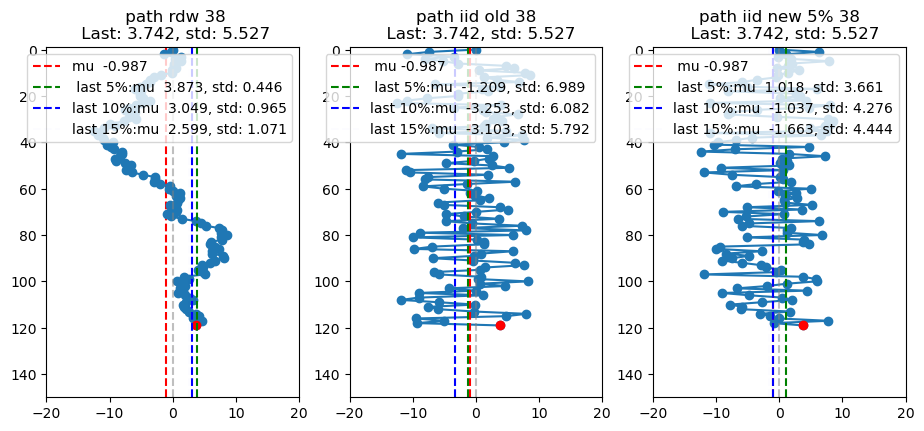

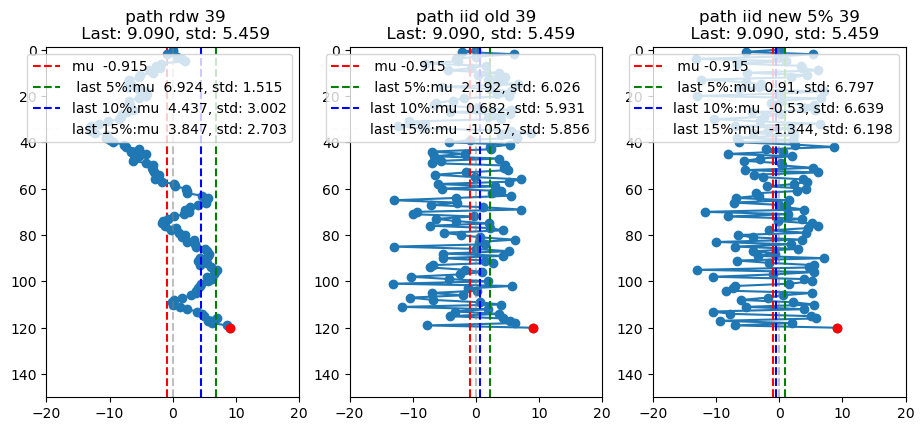

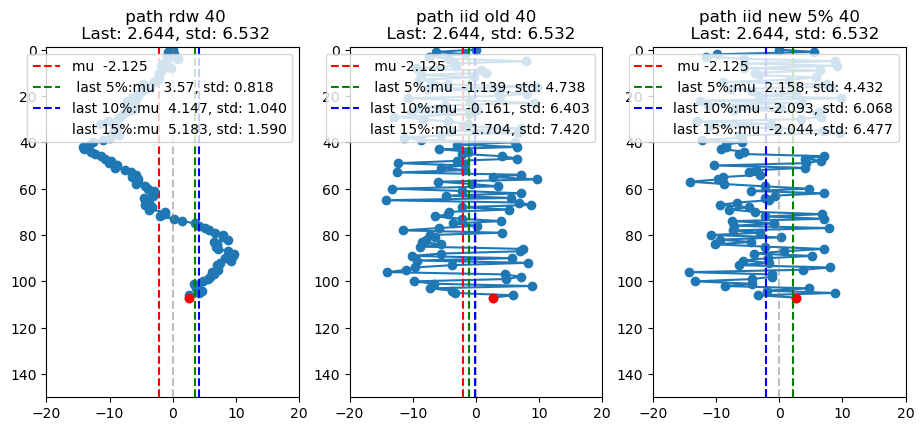

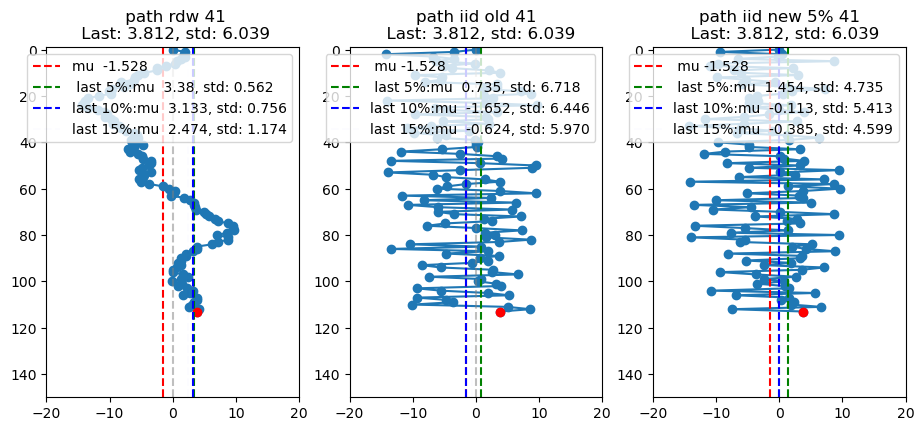

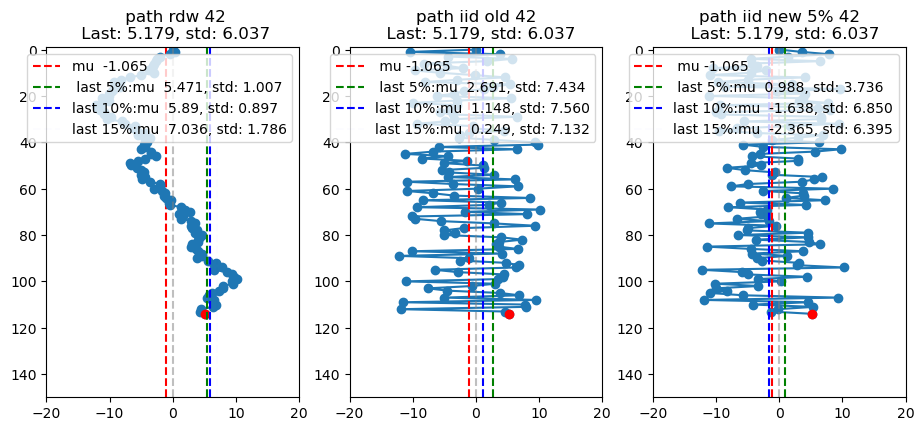

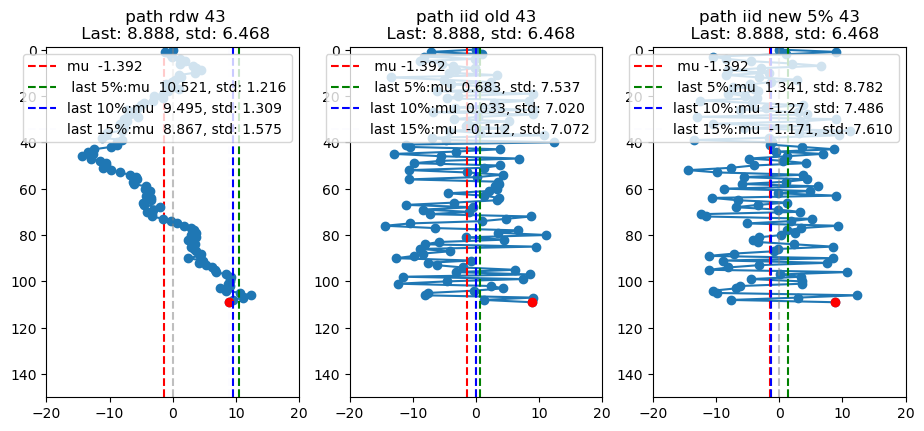

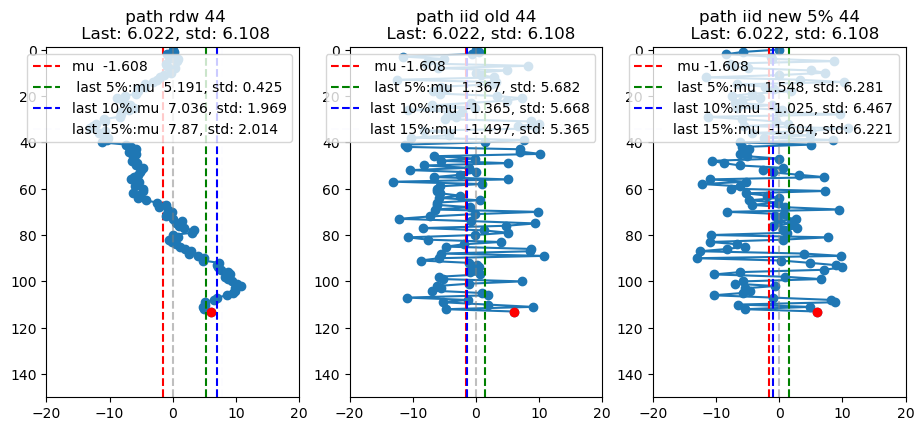

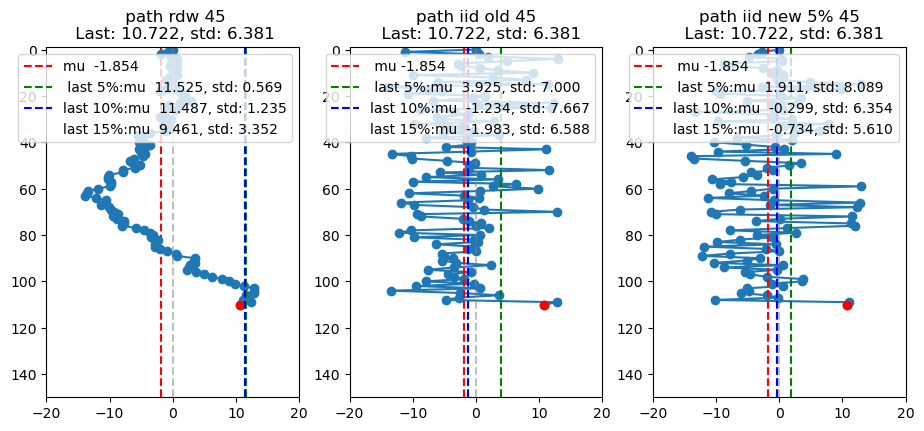

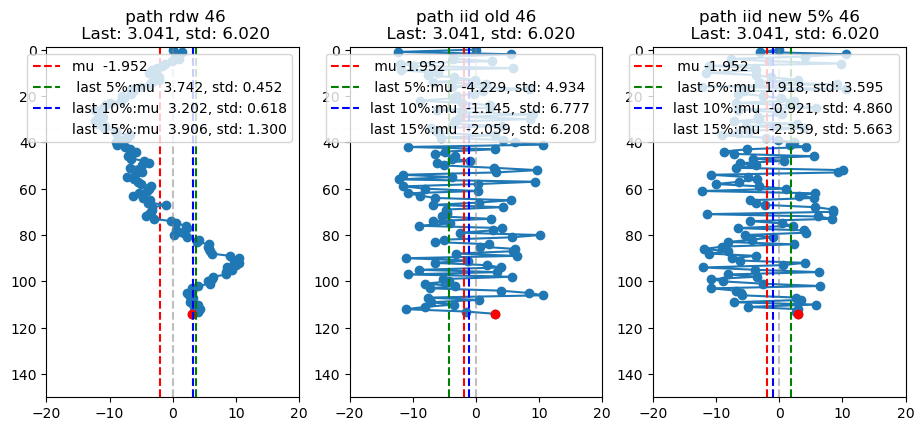

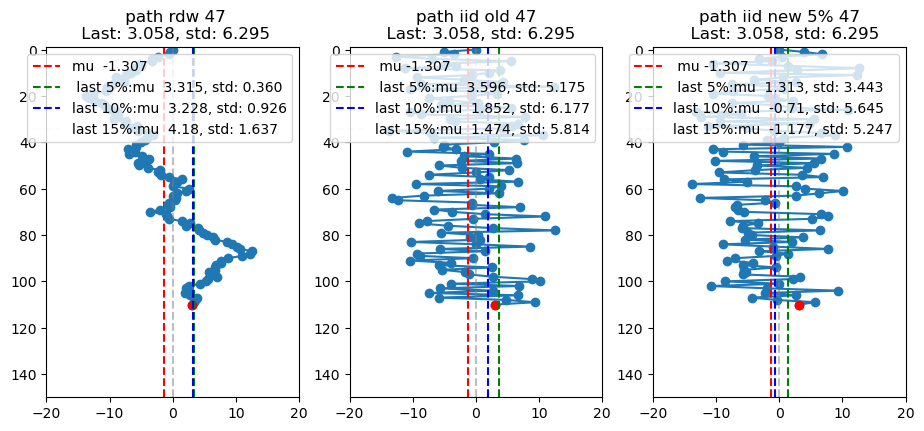

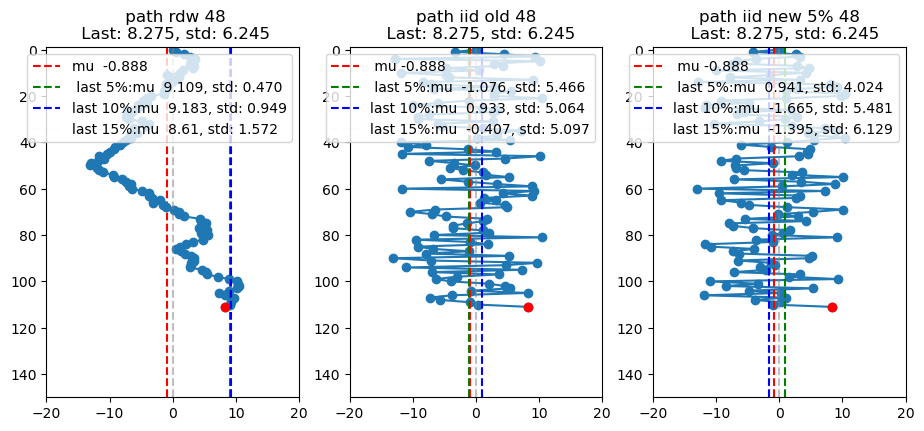

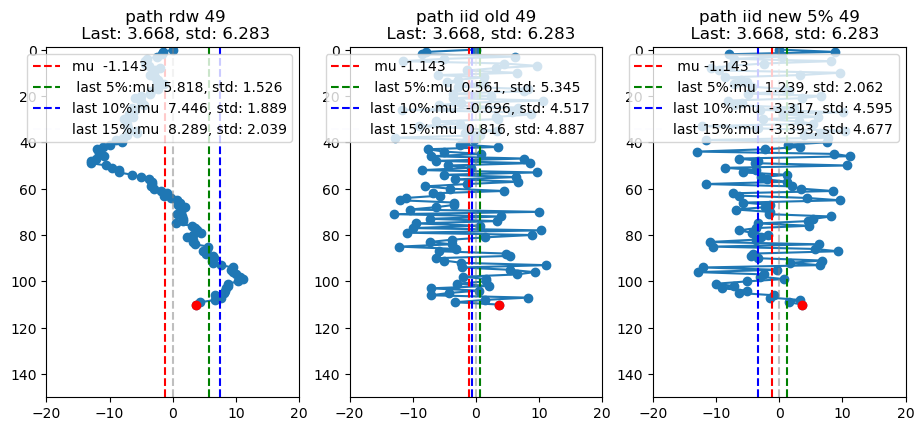

In [20]:

for i in range(len(iid_lr)):
    fig = plt.figure(figsize=(15, 10))
#     plt.subplot(2, 4, 4)
#     iid_trajectory = iid_lr_last15[i]
#     mean_iid = round(np.mean(iid_trajectory),3)
    
#     last_5_percent = int(len(iid_trajectory)*0.05)
#     last_10_percent = int(len(iid_trajectory)*0.10)
#     last_15_percent = int(len(iid_trajectory)*0.15)
#     mean_last_5_iid = round(np.mean(iid_trajectory[-last_5_percent:]),3)
#     mean_last_10_iid = round(np.mean(iid_trajectory[-last_10_percent:]),3)
#     mean_last_15_iid = round(np.mean(iid_trajectory[-last_15_percent:]),3)
    
#     plt.plot(iid_trajectory, range(len(iid_trajectory)), 'o-', )
#     plt.plot(iid_trajectory[-1], len(iid_trajectory) - 1, 'o', color='red')
#     plt.axvline(x=mean_iid, color='red', linestyle='--', label=f' mu {mean_iid}')
#     plt.axvline(x=0, color='gray', linestyle='--',alpha = 0.5)
#     plt.axvline(x=mean_last_5_iid, color='green', linestyle='--', 
#                 label=f' last 5%:mu  {mean_last_5_iid}, std: {np.std(iid_trajectory[-last_5_percent:]):.3f}')
#     plt.axvline(x=mean_last_10_iid, color='blue', linestyle='--', 
#                 label=f'last 10%:mu  {mean_last_10_iid}, std: {np.std(iid_trajectory[-last_10_percent:]):.3f}')
#     plt.axvline(x=mean_last_15_iid, color='blue', linestyle='--', alpha = 0.01,
#                 label=f'last 15%:mu  {mean_last_15_iid}, std: {np.std(iid_trajectory[-last_15_percent:]):.3f}')
#     plt.title(f'path iid new 15 % {i}\n  Last: {iid_trajectory[-1]:.3f}, std: {np.std(iid_trajectory):.3f}')
#     plt.xlim(-20, 20)
#     plt.ylim(150, -1)
#     plt.legend(loc='upper right')

    

    plt.subplot(2, 4, 3)
    iid_trajectory = iid_lr_last5[i]
    mean_iid = round(np.mean(iid_trajectory),3)
    
    last_5_percent = int(len(iid_trajectory)*0.05)
    last_10_percent = int(len(iid_trajectory)*0.10)
    last_15_percent = int(len(iid_trajectory)*0.15)
    mean_last_5_iid = round(np.mean(iid_trajectory[-last_5_percent:]),3)
    mean_last_10_iid = round(np.mean(iid_trajectory[-last_10_percent:]),3)
    mean_last_15_iid = round(np.mean(iid_trajectory[-last_15_percent:]),3)
    
    plt.plot(iid_trajectory, range(len(iid_trajectory)), 'o-', )
    plt.plot(iid_trajectory[-1], len(iid_trajectory) - 1, 'o', color='red')
    plt.axvline(x=mean_iid, color='red', linestyle='--', label=f' mu {mean_iid}')
    plt.axvline(x=0, color='gray', linestyle='--',alpha = 0.5)
    plt.axvline(x=mean_last_5_iid, color='green', linestyle='--', 
                label=f' last 5%:mu  {mean_last_5_iid}, std: {np.std(iid_trajectory[-last_5_percent:]):.3f}')
    plt.axvline(x=mean_last_10_iid, color='blue', linestyle='--', 
                label=f'last 10%:mu  {mean_last_10_iid}, std: {np.std(iid_trajectory[-last_10_percent:]):.3f}')
    plt.axvline(x=mean_last_15_iid, color='blue', linestyle='--', alpha = 0.01,
                label=f'last 15%:mu  {mean_last_15_iid}, std: {np.std(iid_trajectory[-last_15_percent:]):.3f}')
    plt.title(f'path iid new 5% {i}\n  Last: {iid_trajectory[-1]:.3f}, std: {np.std(iid_trajectory):.3f}')
    plt.xlim(-20, 20)
    plt.ylim(150, -1)
    plt.legend(loc='upper right')
  
    plt.subplot(2, 4, 1)
    rdw_trajectory = rdw_lr[i]
    mean_rdw = np.mean(rdw_trajectory)
    last_5_percent = int(len(rdw_trajectory)*0.05)
    last_10_percent = int(len(rdw_trajectory)*0.10)
    last_15_percent = int(len(rdw_trajectory)*0.15)
    mean_last_5_rdw = round(np.mean(rdw_trajectory[-last_5_percent:]),3)
    mean_last_10_rdw = round(np.mean(rdw_trajectory[-last_10_percent:]),3)
    mean_last_15_rdw = round(np.mean(rdw_trajectory[-last_15_percent:]),3)
    
    
    plt.axvline(x=mean_rdw, color='red', linestyle='--', label=f'mu  {mean_rdw:.3f}')
    plt.plot(rdw_trajectory, range(len(rdw_trajectory)), 'o-', )
    plt.plot(rdw_trajectory[-1], len(rdw_trajectory) - 1, 'o', color='red')
    plt.axvline(x=mean_last_5_rdw, color='green', linestyle='--', 
                label=f' last 5%:mu  {mean_last_5_rdw}, std: {np.std(rdw_trajectory[-last_5_percent:]):.3f}')
    plt.axvline(x=mean_last_10_rdw, color='blue', linestyle='--', 
                label=f'last 10%:mu  {mean_last_10_rdw}, std: {np.std(rdw_trajectory[-last_10_percent:]):.3f}')
    plt.axvline(x=mean_last_15_rdw, color='blue', linestyle='--', alpha = 0.01,
                label=f'last 15%:mu  {mean_last_15_rdw}, std: {np.std(rdw_trajectory[-last_15_percent:]):.3f}')
    plt.axvline(x=0, color='gray', linestyle='--',alpha = 0.5)
    plt.gca().invert_yaxis()
    plt.title(f' path rdw {i}\n Last: {rdw_trajectory[-1]:.3f}, std: {np.std(rdw_trajectory):.3f}')
    plt.xlim(-20, 20)
    plt.ylim(150, -1)
    plt.legend(loc='upper right')
    
    plt.subplot(2, 4, 2)
    
    iid_trajectory_old = iid_lr[i]
    mean_iid_old = round(np.mean(iid_trajectory_old),3)
    last_5_percent = int(len(iid_trajectory_old)*0.05)
    last_10_percent = int(len(iid_trajectory_old)*0.10)
    last_15_percent = int(len(iid_trajectory_old)*0.15)
    mean_last_5_iid_old = round(np.mean(iid_trajectory_old[-last_5_percent:]),3)
    mean_last_10_iid_old = round(np.mean(iid_trajectory_old[-last_10_percent:]),3)
    mean_last_15_iid_old = round(np.mean(iid_trajectory_old[-last_15_percent:]),3)

    plt.plot(iid_trajectory_old, range(len(iid_trajectory_old)), 'o-', )
    plt.plot(iid_trajectory_old[-1], len(iid_trajectory_old) - 1, 'o', color='red')
    plt.axvline(x=mean_iid, color='red', linestyle='--', label=f' mu {mean_iid_old}')
    plt.axvline(x=0, color='gray', linestyle='--',alpha = 0.5)
    plt.axvline(x=mean_last_5_iid_old, color='green', linestyle='--', 
                label=f' last 5%:mu  {mean_last_5_iid_old}, std: {np.std(iid_trajectory_old[-last_5_percent:]):.3f}')
    plt.axvline(x=mean_last_10_iid_old, color='blue', linestyle='--', 
                label=f'last 10%:mu  {mean_last_10_iid_old}, std: {np.std(iid_trajectory_old[-last_10_percent:]):.3f}')
    plt.axvline(x=mean_last_15_iid_old, color='blue', linestyle='--', alpha = 0.01,
                label=f'last 15%:mu  {mean_last_15_iid_old}, std: {np.std(iid_trajectory_old[-last_15_percent:]):.3f}')
    plt.title(f'path iid old {i}\n  Last: {iid_trajectory_old[-1]:.3f}, std: {np.std(iid_trajectory_old):.3f}')
    plt.xlim(-20, 20)
    plt.ylim(150, -1)
    plt.legend(loc='upper right')

#     if i >= 4: 
#         break



In [ ]:
## iid_opp_lastSame

In [24]:
def check_mean_condition_5_same(iid_trajectory, original_mean, tolerance=0.1):
    last_5_percent = int(len(iid_trajectory)*0.05)
    mean_last_5 = np.mean(iid_trajectory[-last_5_percent:])
    last_10_percent = int(len(iid_trajectory) * 0.1)
    mean_last_10 = np.mean(iid_trajectory[-last_10_percent:])
    last_15_percent = int(len(iid_trajectory) * 0.15)
    mean_last_15 = np.mean(iid_trajectory[-last_15_percent:])
    return (np.abs(original_mean - mean_last_5) <= tolerance  and np.sign(original_mean) == np.sign(mean_last_5) and
             np.sign(original_mean) != np.sign(mean_last_15) and np.sign(original_mean) != np.sign(mean_last_10))

def check_mean_condition_15_same(iid_trajectory, original_mean, tolerance=0.1):
    last_5_percent = int(len(iid_trajectory) * 0.05)
    mean_last_5 = np.mean(iid_trajectory[-last_5_percent:])
    last_10_percent = int(len(iid_trajectory) * 0.1)
    mean_last_10 = np.mean(iid_trajectory[-last_10_percent:])
    last_15_percent = int(len(iid_trajectory) * 0.15)
    mean_last_15 = np.mean(iid_trajectory[-last_15_percent:])
#     mean_last_5 = np.mean(iid_trajectory[-5:])
#     mean_last_10 = np.mean(iid_trajectory[-10:])
#     mean_last_15 = np.mean(iid_trajectory[-15:])

    return (np.sign(original_mean) == np.sign(mean_last_10) and 
            np.abs(original_mean - mean_last_15) <= tolerance and np.sign(original_mean) == np.sign(mean_last_15) and 
           np.abs(original_mean - mean_last_5) <= tolerance and np.sign(original_mean) == np.sign(mean_last_5))
   

def make_new_iid_same (rdw_samples, num_last):
    max_attempts =100000
    iid_trajectories = []
    for i in range(len(rdw_samples)):
        elem = rdw_samples[i]
        original_mean = np.mean(elem)
        condition_met = False
        attempts = 0 
        while not condition_met and attempts < max_attempts:
            iid = np.random.choice(elem[1:-1], len(elem)-2, replace=False)
            iid = np.insert(iid, 0, elem[0])  # same start like RDW
            iid = np.append(iid, elem[-1])   # same end like RDW
            
            # Check mean condition
            if num_last == "5":
                
                condition_met = check_mean_condition_5_same(iid, original_mean)
    #         condition_met = check_mean_condition(iid, elem)
            else:
                condition_met = check_mean_condition_15_same(iid, original_mean)
            attempts += 1 
#         iid_trajectories.append(iid)
        if condition_met:
            iid_trajectories.append(iid)
            print(f"{i} -- ok")
        else:
            iid_trajectories.append(np.zeros((150,), dtype=int))
            print(f"{i} --fail after  {max_attempts} .")
        
    return  iid_trajectories

In [25]:
iid_lr_last5_same = make_new_iid_same(rdw_lr, "5")

0 --fail after  100000 .
1 -- ok
2 --fail after  100000 .
3 -- ok
4 -- ok
5 -- ok
6 -- ok
7 --fail after  100000 .
8 --fail after  100000 .
9 -- ok
10 -- ok
11 -- ok
12 -- ok
13 -- ok
14 -- ok
15 -- ok
16 -- ok
17 -- ok
18 -- ok
19 --fail after  100000 .
20 -- ok
21 -- ok
22 -- ok
23 -- ok
24 -- ok
25 -- ok
26 -- ok
27 -- ok
28 -- ok
29 -- ok
30 -- ok
31 -- ok
32 -- ok
33 -- ok
34 -- ok
35 -- ok
36 -- ok
37 -- ok
38 -- ok
39 -- ok
40 -- ok
41 -- ok
42 -- ok
43 -- ok
44 -- ok
45 -- ok
46 -- ok
47 -- ok
48 -- ok
49 -- ok


In [ ]:
iid_lr_last15_same = make_new_iid_same(rdw_lr, "15")

In [ ]:
for i in range(len( iid_lr_last5_same)):
    elem = iid_lr_last5_same[i]
    last = int(len(elem) * 0.05)
    total = np.round(np.mean(elem),2)
    last = np.round(np.mean(elem[-int(len(elem) * 0.05):]),2)

    print(i, total,last, np.abs(total - last)) 

In [ ]:
for i in range(len( iid_lr_last15_same)):
    elem = iid_lr_last15_same[i]
    last = int(len(elem) * 0.05)
    total = np.round(np.mean(elem),2)
    last = np.round(np.mean(elem[-int(len(elem) * 0.15):]),2)

    print(i, total,last, np.abs(total - last)) 

In [ ]:
iid_lr_last5_save_same = save_csv (iid_lr_last5_same , 'iid_lr_last_5_same.csv')
iid_lr_last15_save_same = save_csv (iid_lr_last15_same , 'iid_lr_last_15_same.csv')

In [26]:
iid_lr_last5_save_same = save_csv (iid_lr_last5_same , 'iid_lr_last_5_same.csv')
iid_lr_last5_save = save_csv (iid_lr_last5 , 'iid_lr_last_5.csv')

In [ ]:
## IID same 

In [ ]:
iid_ll_last5 = make_new_iid (rdw_ll, "5")

In [ ]:
def check_mean_condition_15(iid_trajectory, original_mean, tolerance=0.3):
    last_5_percent = int(len(iid_trajectory) * 0.05)
    mean_last_5 = np.mean(iid_trajectory[-last_5_percent:])
    last_10_percent = int(len(iid_trajectory) * 0.1)
    mean_last_10 = np.mean(iid_trajectory[-last_10_percent:])
    last_15_percent = int(len(iid_trajectory) * 0.15)
    mean_last_15 = np.mean(iid_trajectory[-last_15_percent:])
#     mean_last_5 = np.mean(iid_trajectory[-5:])
#     mean_last_10 = np.mean(iid_trajectory[-10:])
#     mean_last_15 = np.mean(iid_trajectory[-15:])

    return (#np.sign(original_mean) != np.sign(mean_last_10) and 
            np.abs(np.abs(original_mean) - np.abs(mean_last_15)) <= tolerance and np.sign(original_mean) != np.sign(mean_last_15) and 
            np.abs(np.abs(original_mean) - np.abs(mean_last_5)) <= 0.2 and np.sign(original_mean) != np.sign(mean_last_5))
   

def make_new_iid (rdw_samples, num_last):
    max_attempts =1000000
    iid_trajectories = []
    for i in range(len(rdw_samples)):
        elem = rdw_samples[i]
        original_mean = np.mean(elem)
        condition_met = False
        attempts = 0 
        while not condition_met and attempts < max_attempts:
            iid = np.random.choice(elem[1:-1], len(elem)-2, replace=False)
            iid = np.insert(iid, 0, elem[0])  # same start like RDW
            iid = np.append(iid, elem[-1])   # same end like RDW
            
            # Check mean condition
            if num_last == "5":
                
                condition_met = check_mean_condition_5(iid, original_mean)
    #         condition_met = check_mean_condition(iid, elem)
            else:
                condition_met = check_mean_condition_15(iid, original_mean)
            attempts += 1 
#         iid_trajectories.append(iid)
        if condition_met:
            iid_trajectories.append(iid)
            print(f"{i} -- ok")
        else:
            iid_trajectories.append(iid)
#             iid_trajectories.append(np.zeros((150,), dtype=int))
            
            print(f"{i} --fail after  {max_attempts} .")
        
    return  iid_trajectories

In [ ]:
iid_ll_last15 = make_new_iid (rdw_ll, "15")

In [ ]:
for i in range(len( iid_ll_last15)):
    elem = iid_ll_last15[i]
    last = int(len(elem) * 0.05)
    total = np.round(np.mean(elem),2)
    last = np.round(np.mean(elem[-int(len(elem) * 0.05):]),2)
    last_10 = np.round(np.mean(elem[-int(len(elem) * 0.1):]),2)
    last_15 = np.round(np.mean(elem[-int(len(elem) * 0.15):]),2)
    print(i, total,last_15, np.abs(np.round(np.abs(total)-np.abs(last_15),2))) 

In [ ]:

for i in range(len(iid_ll)):
    fig = plt.figure(figsize=(15, 10))
    plt.subplot(2, 4, 4)
    iid_trajectory = iid_ll_last15[i]
    mean_iid = round(np.mean(iid_trajectory),3)
    
    last_5_percent = int(len(iid_trajectory)*0.05)
    last_10_percent = int(len(iid_trajectory)*0.10)
    last_15_percent = int(len(iid_trajectory)*0.15)
    mean_last_5_iid = round(np.mean(iid_trajectory[-last_5_percent:]),3)
    mean_last_10_iid = round(np.mean(iid_trajectory[-last_10_percent:]),3)
    mean_last_15_iid = round(np.mean(iid_trajectory[-last_15_percent:]),3)
    
    plt.plot(iid_trajectory, range(len(iid_trajectory)), 'o-', )
    plt.plot(iid_trajectory[-1], len(iid_trajectory) - 1, 'o', color='red')
    plt.axvline(x=mean_iid, color='red', linestyle='--', label=f' mu {mean_iid}')
    plt.axvline(x=0, color='gray', linestyle='--',alpha = 0.5)
    plt.axvline(x=mean_last_5_iid, color='green', linestyle='--', 
                label=f' last 5%:mu  {mean_last_5_iid}, std: {np.std(iid_trajectory[-last_5_percent:]):.3f}')
    plt.axvline(x=mean_last_10_iid, color='blue', linestyle='--', 
                label=f'last 10%:mu  {mean_last_10_iid}, std: {np.std(iid_trajectory[-last_10_percent:]):.3f}')
    plt.axvline(x=mean_last_15_iid, color='blue', linestyle='--', alpha = 0.01,
                label=f'last 15%:mu  {mean_last_15_iid}, std: {np.std(iid_trajectory[-last_15_percent:]):.3f}')
    plt.title(f'path iid new 15 % {i}\n  Last: {iid_trajectory[-1]:.3f}, std: {np.std(iid_trajectory):.3f}')
    plt.xlim(-20, 20)
    plt.ylim(150, -1)
    plt.legend(loc='upper right')

    

    plt.subplot(2, 4, 3)
    iid_trajectory = iid_ll_last5[i]
    mean_iid = round(np.mean(iid_trajectory),3)
    
    last_5_percent = int(len(iid_trajectory)*0.05)
    last_10_percent = int(len(iid_trajectory)*0.10)
    last_15_percent = int(len(iid_trajectory)*0.15)
    mean_last_5_iid = round(np.mean(iid_trajectory[-last_5_percent:]),3)
#     mean_last_10_iid = round(np.mean(iid_trajectory[-last_10_percent:]),3)
#     mean_last_15_iid = round(np.mean(iid_trajectory[-last_15_percent:]),3)
    
    plt.plot(iid_trajectory, range(len(iid_trajectory)), 'o-', )
    plt.plot(iid_trajectory[-1], len(iid_trajectory) - 1, 'o', color='red')
    plt.axvline(x=mean_iid, color='red', linestyle='--', label=f' mu {mean_iid}')
    plt.axvline(x=0, color='gray', linestyle='--',alpha = 0.5)
    plt.axvline(x=mean_last_5_iid, color='green', linestyle='--', 
                label=f' last 5%:mu  {mean_last_5_iid}, std: {np.std(iid_trajectory[-last_5_percent:]):.3f}')

    plt.title(f'path iid new 5% {i}\n  Last: {iid_trajectory[-1]:.3f}, std: {np.std(iid_trajectory):.3f}')
    plt.xlim(-20, 20)
    plt.ylim(150, -1)
    plt.legend(loc='upper right')
  
    plt.subplot(2, 4, 1)
    rdw_trajectory = rdw_ll[i]
    mean_rdw = np.mean(rdw_trajectory)
    last_5_percent = int(len(rdw_trajectory)*0.05)
    last_10_percent = int(len(rdw_trajectory)*0.10)
    last_15_percent = int(len(rdw_trajectory)*0.15)
    mean_last_5_rdw = round(np.mean(rdw_trajectory[-last_5_percent:]),3)
    mean_last_10_rdw = round(np.mean(rdw_trajectory[-last_10_percent:]),3)
    mean_last_15_rdw = round(np.mean(rdw_trajectory[-last_15_percent:]),3)
    
    
    plt.axvline(x=mean_rdw, color='red', linestyle='--', label=f'mu  {mean_rdw:.3f}')
    plt.plot(rdw_trajectory, range(len(rdw_trajectory)), 'o-', )
    plt.plot(rdw_trajectory[-1], len(rdw_trajectory) - 1, 'o', color='red')
    plt.axvline(x=mean_last_5_rdw, color='green', linestyle='--', 
                label=f' last 5%:mu  {mean_last_5_rdw}, std: {np.std(rdw_trajectory[-last_5_percent:]):.3f}')
    plt.axvline(x=mean_last_10_rdw, color='blue', linestyle='--', 
                label=f'last 10%:mu  {mean_last_10_rdw}, std: {np.std(rdw_trajectory[-last_10_percent:]):.3f}')
    plt.axvline(x=mean_last_15_rdw, color='blue', linestyle='--', alpha = 0.01,
                label=f'last 15%:mu  {mean_last_15_rdw}, std: {np.std(rdw_trajectory[-last_15_percent:]):.3f}')
    plt.axvline(x=0, color='gray', linestyle='--',alpha = 0.5)
    plt.gca().invert_yaxis()
    plt.title(f' path rdw {i}\n Last: {rdw_trajectory[-1]:.3f}, std: {np.std(rdw_trajectory):.3f}')
    plt.xlim(-20, 20)
    plt.ylim(150, -1)
    plt.legend(loc='upper right')
    
    plt.subplot(2, 4, 2)
    
    iid_trajectory_old = iid_ll[i]
    mean_iid_old = round(np.mean(iid_trajectory_old),3)
    last_5_percent = int(len(iid_trajectory_old)*0.05)
    last_10_percent = int(len(iid_trajectory_old)*0.10)
    last_15_percent = int(len(iid_trajectory_old)*0.15)
    mean_last_5_iid_old = round(np.mean(iid_trajectory_old[-last_5_percent:]),3)
    mean_last_10_iid_old = round(np.mean(iid_trajectory_old[-last_10_percent:]),3)
    mean_last_15_iid_old = round(np.mean(iid_trajectory_old[-last_15_percent:]),3)

    plt.plot(iid_trajectory_old, range(len(iid_trajectory_old)), 'o-', )
    plt.plot(iid_trajectory_old[-1], len(iid_trajectory_old) - 1, 'o', color='red')
    plt.axvline(x=mean_iid, color='red', linestyle='--', label=f' mu {mean_iid_old}')
    plt.axvline(x=0, color='gray', linestyle='--',alpha = 0.5)
    plt.axvline(x=mean_last_5_iid_old, color='green', linestyle='--', 
                label=f' last 5%:mu  {mean_last_5_iid_old}, std: {np.std(iid_trajectory_old[-last_5_percent:]):.3f}')
    plt.axvline(x=mean_last_10_iid_old, color='blue', linestyle='--', 
                label=f'last 10%:mu  {mean_last_10_iid_old}, std: {np.std(iid_trajectory_old[-last_10_percent:]):.3f}')
    plt.axvline(x=mean_last_15_iid_old, color='blue', linestyle='--', alpha = 0.01,
                label=f'last 15%:mu  {mean_last_15_iid_old}, std: {np.std(iid_trajectory_old[-last_15_percent:]):.3f}')
    plt.title(f'path iid old {i}\n  Last: {iid_trajectory_old[-1]:.3f}, std: {np.std(iid_trajectory_old):.3f}')
    plt.xlim(-20, 20)
    plt.ylim(150, -1)
    plt.legend(loc='upper right')

#     if i >= 4: 
#         break



In [ ]:
# iid_lr_last5_save = save_csv (iid_lr_last5 , 'iid_lr_last_5.csv')
# iid_lr_last15_save = save_csv (iid_lr_last15 , 'iid_lr_last_15.csv')

# iid_ll_last5_save = save_csv (iid_ll_last5 , 'iid_ll_last_5.csv')
# iid_ll_last15_save = save_csv (iid_ll_last15 , 'iid_ll_last_15.csv')

In [28]:
# make mirror

stim_csv =  sorted(str(p) for p in pathlib.Path("C:/Users/USER/Desktop/Paris Saclay/These/2_SCRIPT/exp_1a/make_path/path_ok_new").glob("*.csv"))
stim_csv 

['C:\\Users\\USER\\Desktop\\Paris Saclay\\These\\2_SCRIPT\\exp_1a\\make_path\\path_ok_new\\iid_lr_last_15_new.csv',
 'C:\\Users\\USER\\Desktop\\Paris Saclay\\These\\2_SCRIPT\\exp_1a\\make_path\\path_ok_new\\iid_lr_last_15_same_new.csv',
 'C:\\Users\\USER\\Desktop\\Paris Saclay\\These\\2_SCRIPT\\exp_1a\\make_path\\path_ok_new\\iid_lr_last_5_new.csv',
 'C:\\Users\\USER\\Desktop\\Paris Saclay\\These\\2_SCRIPT\\exp_1a\\make_path\\path_ok_new\\iid_lr_last_5_same_new.csv']

In [29]:
iid_left_right_15 = pd.read_csv(stim_csv [0], header=None, sep = ";").to_numpy()
iid_left_right_15_same = pd.read_csv(stim_csv [1], header=None, sep = ";").to_numpy()
iid_left_right_5 = pd.read_csv(stim_csv [2], header=None, sep = ";").to_numpy()

iid_left_right_5_same = pd.read_csv(stim_csv [3], header=None, sep = ";").to_numpy()


In [ ]:
# iid_left_left_15 = pd.read_csv(stim_csv [0], header=None, sep = ";").to_numpy()
# iid_left_left_5 = pd.read_csv(stim_csv [1], header=None, sep = ";").to_numpy()
# iid_left_right_15 = pd.read_csv(stim_csv [2], header=None, sep = ";").to_numpy()
# iid_left_right_5 = pd.read_csv(stim_csv [3], header=None, sep = ";").to_numpy()

In [ ]:
iid_10 = iid_left_left_15[4:,10]

In [ ]:
inv = len(np.where(iid_left_left_15[5:,10] == 0)[0])
inv 

In [ ]:
for i in range(iid_left_left_5.shape[1]):
    fig = plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 2)
    inv = len(np.where(iid_left_left_5[5:,i] == 0)[0])
    iid_trajectory = iid_left_left_5[4:-(inv),i]
    mean_iid = round(np.mean(iid_trajectory),3)
    
    last_5_percent = int(len(iid_trajectory)*0.05)
    last_10_percent = int(len(iid_trajectory)*0.10)
    last_15_percent = int(len(iid_trajectory)*0.15)
    mean_last_5_iid = round(np.mean(iid_trajectory[-last_5_percent:]),3)
    mean_last_10_iid = round(np.mean(iid_trajectory[-last_10_percent:]),3)
    mean_last_15_iid = round(np.mean(iid_trajectory[-last_15_percent:]),3)
    
    plt.plot(iid_trajectory, range(len(iid_trajectory)), 'o-', )
    plt.plot(iid_trajectory[-1], len(iid_trajectory) - 1, 'o', color='red')
    plt.axvline(x=mean_iid, color='red', linestyle='--', label=f' mu {mean_iid}')
    plt.axvline(x=0, color='gray', linestyle='--',alpha = 0.5)
    plt.axvline(x=mean_last_5_iid, color='green', linestyle='--', 
                label=f' last 5%:mu  {mean_last_5_iid}, std: {np.std(iid_trajectory[-last_5_percent:]):.3f}')
    plt.axvline(x=mean_last_10_iid, color='blue', linestyle='--', 
                label=f'last 10%:mu  {mean_last_10_iid}, std: {np.std(iid_trajectory[-last_10_percent:]):.3f}')
    plt.axvline(x=mean_last_15_iid, color='blue', linestyle='--', alpha = 0.01,
                label=f'last 15%:mu  {mean_last_15_iid}, std: {np.std(iid_trajectory[-last_15_percent:]):.3f}')
    plt.title(f'path iid new 15 % {i}\n  Last: {iid_trajectory[-1]:.3f}, std: {np.std(iid_trajectory):.3f}')
    plt.xlim(-20, 20)
    plt.ylim(150, -1)
    plt.legend(loc='upper right')
    
    

In [31]:
iid_right_left_15_same = iid_left_right_15_same.copy()
iid_right_left_5_same = iid_left_right_5_same.copy()
iid_right_left_15 = iid_left_right_15.copy()
iid_right_left_5 = iid_left_right_5.copy()

In [32]:
iid_right_left_15_same[4:,] = iid_left_right_15_same[4:,]*(-1)
iid_right_left_5_same[4:,] = iid_left_right_5_same[4:,]*(-1)
iid_right_left_15[4:,] = iid_left_right_15[4:,]*(-1)
iid_right_left_5[4:,] = iid_left_right_5[4:,]*(-1)

In [41]:
np.round(np.mean(iid_right_left_15_same[4:,],axis=0)+np.mean(iid_left_right_15_same[4:,],axis=0),10)

array([ 0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,
        0.,  0.,  0., -0.,  0., -0.,  0., -0.,  0.,  0., -0., -0.])

In [42]:
np.round(np.mean(iid_right_left_5_same[4:,],axis=0)+np.mean(iid_left_right_5_same[4:,],axis=0),10)

array([ 0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,
       -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0.])

In [44]:
np.round(np.mean(iid_right_left_15[4:,],axis=0)+np.mean(iid_left_right_15[4:,],axis=0),10)


array([ 0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.])

In [30]:
# iid_right_right_15 = iid_left_left_15.copy()
# iid_right_right_5 = iid_left_left_5.copy()
# iid_right_right_15[4:,] = iid_left_left_15[4:,] *(-1)
# iid_right_right_5[4:,] = iid_left_left_5[4:,] *(-1)

In [45]:
np.savetxt('iid_right_left_15_same.csv', iid_right_left_15_same, delimiter=';')
np.savetxt('iid_right_left_5_same.csv', iid_right_left_5_same, delimiter=';')
np.savetxt('iid_right_left_15.csv', iid_right_left_15, delimiter=';')
np.savetxt('iid_right_left_5.csv', iid_right_left_5, delimiter=';')

In [46]:
iid_opposite_same = np.hstack([iid_left_right_5_same,iid_right_left_5_same, iid_left_right_15_same,iid_right_left_15_same])

In [47]:
iid_opposite_opposite = np.hstack([iid_left_right_5,iid_right_left_5, iid_left_right_15,iid_right_left_15])

In [48]:
np.savetxt('iid_opposite_opposite.csv', iid_opposite_opposite, delimiter=';')
np.savetxt('iid_opposite_same.csv', iid_opposite_same, delimiter=';')

In [ ]:
# iid_same = np.hstack([iid_left_left_5,iid_right_right_5,iid_left_left_15,iid_right_right_15,])


In [ ]:
# np.savetxt('iid_same.csv', iid_same, delimiter=';')
# np.savetxt('iid_opposite.csv', iid_opposite, delimiter=';')

In [49]:
full_condition_op_same = np.hstack([iid_opposite_opposite,iid_opposite_same])
np.savetxt('iid_all_op_same.csv', full_condition_op_same, delimiter=';')

In [ ]:
full_condition = np.hstack([iid_same,iid_opposite])
np.savetxt('iid_all.csv', full_condition, delimiter=';')

In [ ]:
# save 
def search_f(path):
    dif = [round(abs(np.sqrt(k) - round(np.std(path[0:-k]), 4)), 4) for k in range(1, int(len(path) * 0.4) + 1)]
    return dif.index(min(dif)) + 1

In [ ]:
def search_f(path):
    dif = []
    for k in range(1, int(len(path) * 0.4) + 1): 
        sd = round(np.std(path[0:-k]), 4) 
        sd_kstep = round(np.sqrt(k), 4) 
        dif.append(round(abs(sd_kstep - sd), 4))
    mi = np.min(dif)
    f = dif.index(mi) 
    return f 

In [ ]:
f_lr = [7,	4,	4,	6,	8,	3,	8,	8,	6,	5,	10,	14,	12,	13,	9,	15,	12,	13,	9,	10,
        19,	21,	23,	21,	18,	21,	21,	18,	16,	21,	24,	30,	28,	28,	29,	23,	28,	29,	30,	29,	42,	36,35,	40,	36,	39,	35,	39,	38,	39]


In [ ]:
f_ll = [4,	7,	5,	4,	4,	4,	7,	5,	3,	7,	8,	9,	11,	10,	9,	8,	9,	15, 9,	11,	17,	23,	21,	15,	16,	17,	21,	16,	19,	18,	26,	32,	25,	26,	26,	25,	34,	29,	
        28,	30,	36,	37,	43,	42,	37,	40,	41,	48,	38,	39]

In [ ]:
# f_lr_5 =[]
# for k in range(iid_left_left_15.shape[1]):
#     f= search_f(iid_left_left_15[:,k])
#     f_ll_5.append(f+1)
# f_lr_5

In [ ]:
# f_ll_5,f_ll_15,f_lr_5,f_lr_15 = [],[],[],[]
# for k in range(iid_left_right_15.shape[1]):
 
#     f_ll_5.append(search_f(iid_left_left_5[:,k])+1)
#     f_ll_15.append(search_f(iid_left_left_15[:,k])+1)
#     f_lr_5.append(search_f(iid_left_right_5[:,k])+1)
#     f_lr_15.append(search_f(iid_left_right_15[:,k])+1)